In [139]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
import copy
import networkx as nx
import torch
#from open_spiel.python.algorithms import random_agent
from igraph import Graph
from os import listdir
from os.path import isfile, join
import sys
sys.path.append("../")
#from utils.reinforcement_learning.dqn_HD import DQN
from utils.reinforcement_learning.dqn_TS import DQN
from utils.hyperparameters.params import Params
from utils.evaluation.evaluationhelper import EvaluateModel,EvaluateACTION
from utils.environment.nodeCentrality import Node_Centrality
from utils.environment.globalFeature import Global_Feature
from utils.validation import get_Validation, area_under_curve
from utils.environment.game import GraphGame
from utils.environment.envhelper import reset
from utils.reinforcement_learning.rl_environment import Environment
from utils.getClass import objective_function,get_class_from_file
def save_action(GRAPH,mix,ba,finder, ci, gdm, corehd):
    ranking = {}
    check = lambda x, y: True if x in y else False
    nodes = np.array([v["name"] for v in GRAPH.vs])
    ranking = np.array(nodes).reshape(-1,1)
    for m, model in enumerate([mix,ba]): 
        value = np.zeros(len(nodes)) + len(nodes)
        for i, removed_node in enumerate(model):
            removed_node = GRAPH.vs["name"][removed_node]
            value[int(removed_node)] = i + 1
        #ranking[m] = value
        ranking  = np.append(ranking, np.array(value).reshape(-1,1), axis=1) 
    for m, model in enumerate([finder, ci, gdm, corehd]):
        value = np.zeros(len(nodes)) + len(nodes)
        for i, removed_node in enumerate(model):
            value[int(removed_node)] = i + 1
        #ranking[m] = value
        ranking  = np.append(ranking,np.array(value).reshape(-1,1), axis=1) 
    
    np.savetxt("./RANKING.csv", ranking,fmt=('%s','%s','%s','%s','%s','%s','%s'))
        
    
def input_graph(graph_path,file):
    GRAPH = Graph.Read_Ncol(graph_path+str(file)+".txt", directed=False)
    nodes = [v.index for v in GRAPH.vs]
    map = {n:int(i) for i, n in enumerate(nodes)}
    GRAPH = reset(GRAPH)  
    Graph.simplify(GRAPH)
    return GRAPH, map

def implement_GNN(model_iteration,parameter_path,GRAPH,useSingleStep= None):
    params = Params(parameter_path)
    objectiveFunction = objective_function("utils/environment/objectiveFunction.py",params.objective_function)
    if objectiveFunction.__name__ == "numberConnectedComponent":
        condMaxNum = True
    else:
        condMaxNum = False
    model = torch.load(params.checkpoint_dir+'_'+str(model_iteration))
    game = GraphGame
    env = Environment(game)
    nodeCentrality = Node_Centrality(params.centrality_feature_name)
    globalFeature = Global_Feature(params.global_feature_name)
    attacker = DQN(state_representation_size=params.centrality_features,
                    hidden_layers_sizes= params.hidden_layers,
                   global_feature_size =params.global_features)
    attacker._q_network.load_state_dict(model["_q_network"])
    attacker._optimizer.load_state_dict(model["_optimizer"])
    rewards, lcc, actions = EvaluateModel(env,objectiveFunction,nodeCentrality,globalFeature, attacker,GRAPH,useSingleStep)
    return rewards, lcc, actions

def implement_random_GNN(agents,GRAPH):
    game = GraphGame
    env = Environment(game)
    rewards, lcc, actions = EvaluateModel(env, agents,GRAPH)
    return rewards, lcc, actions
    
def implement_Bench(fname,GRAPH,objectiveFunction,indexOn = False):
    if objectiveFunction.__name__ == "numberConnectedComponent":
        condMaxNum = True
    else:
        condMaxNum = False
    action_list = np.loadtxt(fname, dtype=int)
    rewards, lcc, actions = EvaluateACTION(action_list,objectiveFunction,GRAPH,indexOn)
    return rewards, lcc, actions
    #GRAPH.vertex["name"],

def visual_evaluation(graph_path,file_list,attacker_ba, attacker_mix,action_list,save = False): 
    AUC  = []
    NodeRemoved = []
    model_name = ["MIX","BA","FINDER","CI","GDM","COREHD"]
    for i, graph_name in enumerate(file_list):
        print(graph_name, end=' ,')
        GRAPH, map = input_graph(graph_path,graph_name)
        N = GRAPH.vcount()
        params = Params(attacker_mix[1]) 
        objectivefunction = params.objective_function
        action = {}
        objectiveFunction = objective_function("utils/environment/objectiveFunction.py",params.objective_function)
        # Trained MIXED
        rewards_mix, lcc_mix, actions_mix = implement_GNN(attacker_mix[0],attacker_mix[1],GRAPH.copy(),useSingleStep=None)
        action["mix"]=lcc_mix
        # Trained BA
        rewards_ba, lcc_ba, actions_ba = implement_GNN(attacker_ba[0],attacker_ba[1],GRAPH.copy(),useSingleStep=None)
        action["ba"]=lcc_ba
        #FINDER MODEl
        #FINDER Best Re-Trained  iteration
        if objectivefunction == "largestConnectedComponent":
            path = "./FINDER/FINDER_ReTrained/"
            fname = path+graph_name+".txt"
            rewards_Finder, lcc_Finder, actions_Finder = implement_Bench(fname,GRAPH.copy(),objectiveFunction,indexOn=True)
            action["finder"]=lcc_Finder
        elif  objectivefunction == "pairwiseConnectivity":
            path = "./FINDER/FINDER_CN/"
            fname = path+graph_name+".txt"
            rewards_Finder, lcc_Finder, actions_Finder = implement_Bench(fname,GRAPH.copy(),objectiveFunction,indexOn=True)
            action["finder"]=lcc_Finder
        else:
            path = "./FINDER/FINDER_MaxNum/"
            fname = path+graph_name+".txt"
            rewards_Finder, lcc_Finder, actions_Finder = implement_Bench(fname,GRAPH.copy(),objectiveFunction,indexOn=True)
            action["finder"]=lcc_Finder
        #CI
        path = "./CI/L_2/" 
        fname = path+graph_name+".txt"
        rewards_CI, lcc_CI, actions_CI = implement_Bench(fname,GRAPH.copy(),objectiveFunction)
        action["ci"]=lcc_CI
        #print(actions_CI)
        #
        #GDM
        if objectivefunction == "largestConnectedComponent":
            path = "./GDM/GDM_MinMax/"
            fname = path+graph_name+".txt"
            rewards_GDM, lcc_GDM, actions_GDM = implement_Bench(fname,GRAPH.copy(),objectiveFunction,indexOn=True)
            action["gdm"]=lcc_GDM
        elif  objectivefunction == "pairwiseConnectivity":
            path = "./GDM/GDM_CN/"
            fname = path+graph_name+".txt"
            rewards_GDM, lcc_GDM, actions_GDM = implement_Bench(fname,GRAPH.copy(),objectiveFunction,indexOn=True)
            action["gdm"]=lcc_GDM
        else:
            path = "./GDM/GDM_MaxNum/"
            fname = path+graph_name+".txt"
            rewards_GDM, lcc_GDM, actions_GDM = implement_Bench(fname,GRAPH.copy(),objectiveFunction,indexOn=True)
            action["gdm"]=lcc_GDM
            

        #CoreHD
        path = "./CoreHD/"
        path = "./CoreHD/COREHD_New/"
        fname = path+graph_name+".txt"
        rewards_CoreHD, lcc_CoreHD, actions_CoreHD =  implement_Bench(fname,GRAPH.copy(),objectiveFunction)
        action["corehd"]=lcc_CoreHD
        if objectivefunction == "largestConnectedComponent": 
            color_model = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02']
            labeling = ['ba', 'mix', 'finder','gdm', 'ci','corehd']
            model_result = [lcc_ba, lcc_mix, lcc_Finder,lcc_GDM, lcc_CI, lcc_CoreHD]
            fname= "MinMax"
            condMaxNum = False
        elif objectivefunction == "pairwiseConnectivity":
            color_model = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02']
            labeling = ['ba', 'mix', 'finder','gdm', 'ci','corehd']
            model_result = [lcc_ba, lcc_mix, lcc_Finder,lcc_GDM,  lcc_CI, lcc_CoreHD]
            fname= "CNP"
            condMaxNum = False
        else:
            color_model = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02']
            labeling = ['ba', 'mix', 'finder','gdm', 'ci','corehd']
            condMaxNum = True
            model_result = [lcc_ba, lcc_mix, lcc_Finder,lcc_GDM, lcc_CI, lcc_CoreHD]
            fname= "MaxNum"
            for m in range(len(model_result)):
                l = np.array(model_result[m])
                model_result[m] = (l[-1] - l + 1)/l[-1]
            
        x =  np.flip(np.arange(N+1)[N:0:-1]/N)
        plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
        plt.figure(figsize=(10,6))        
        for color_code, lcc in enumerate(model_result):
            plt.plot(x[:len(lcc)],np.array(lcc)/lcc[0], color = color_model[color_code],label= labeling[color_code].upper())
        plt.title(graph_name, fontdict={'fontsize': 18})
        plt.legend(loc="upper right")
        plt.xlabel("Fraction of Nodes Removed")
        if objectiveFunction == "numberConnectedComponent":
            plt.ylabel("N -"+ objectivefunction+"/N")
        else:
            plt.ylabel(objectivefunction+"/N")
        if False:
            plt.savefig("./Figure/Compiled/HDA/SingleFigure/"+fname+"_"+graph_name+".pdf")
        plt.show()
        if fname in action_list:
            action_list[fname][graph_name] = action
        else:
            action_list[fname] = {}
            action_list[fname][graph_name] = action
    return action_list

In [140]:
import json
import sys
import json
from utils.evaluation.jsonEncoder import NpEncoder
def get_from_json(file_path):
    with open(file_path) as json_file:
        data = json.load(json_file)
    return data
actions_list = get_from_json("./Figure/Compiled/HDA/SingleFigure/real_world.json")#{"largestConnectedComponent":{},"pairwiseConnectivity":{},"numberConnectedComponent":{}}


# Real World Dataset: MinMax Problem - Largest Connected Component

onion_200_2.5_2 ,

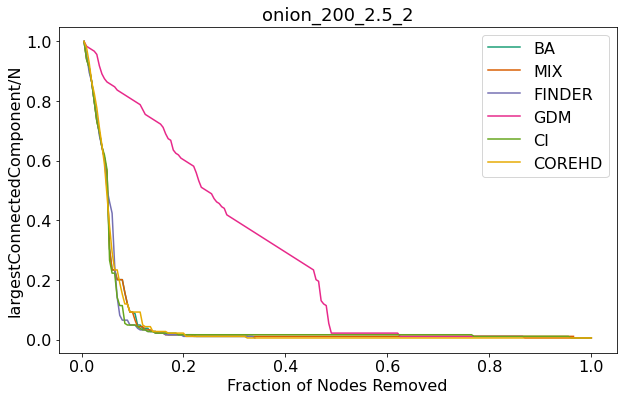

onion_200_2.5_5 ,

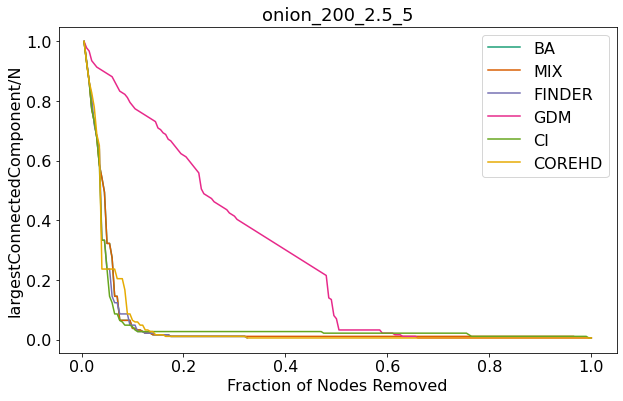

onion_400_2.5_3 ,

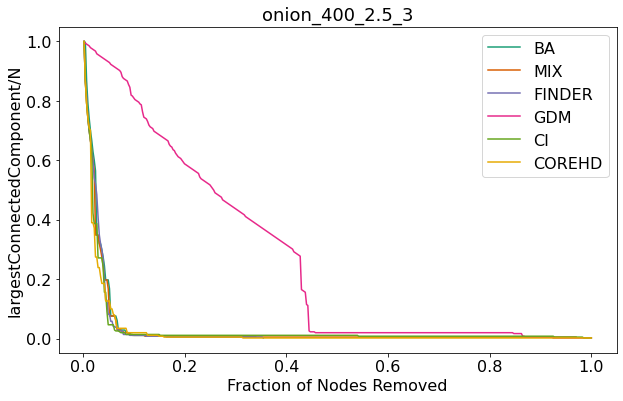

onion_500_2.5_2 ,

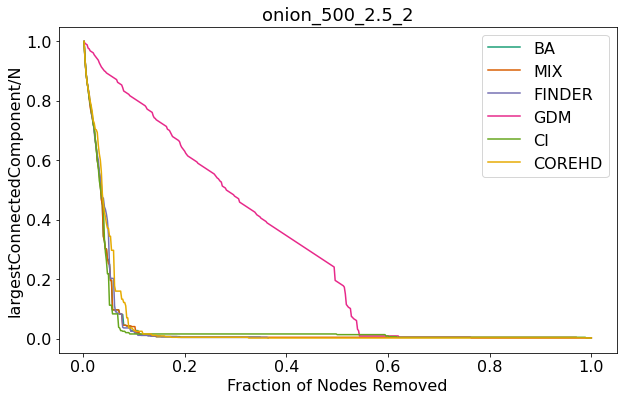

onion_100_2.5_5 ,

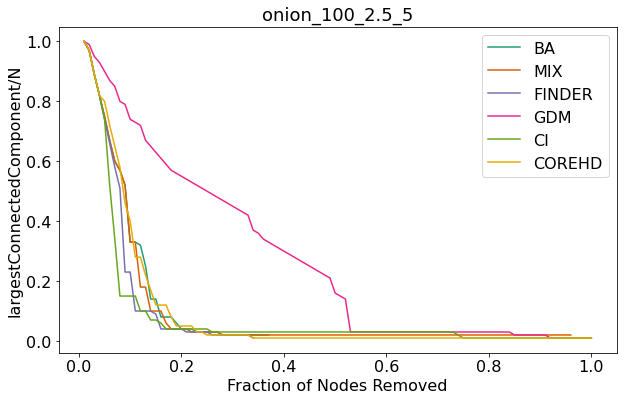

onion_400_2.5_5 ,

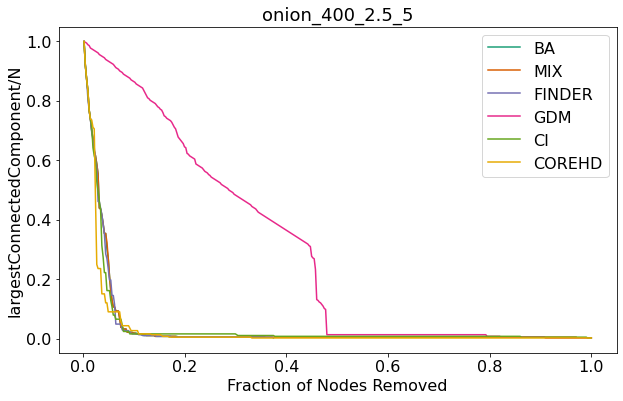

onion_300_2.5_1 ,

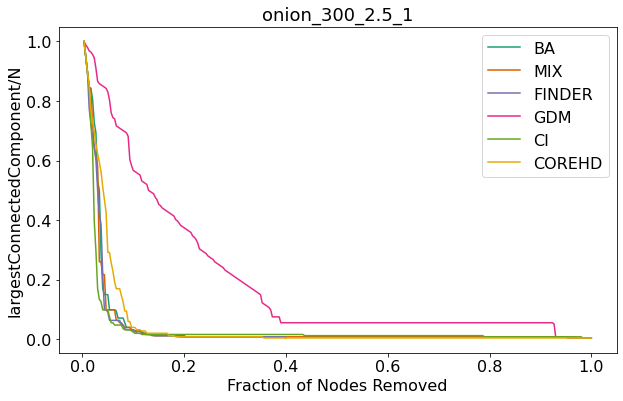

onion_400_2.5_2 ,

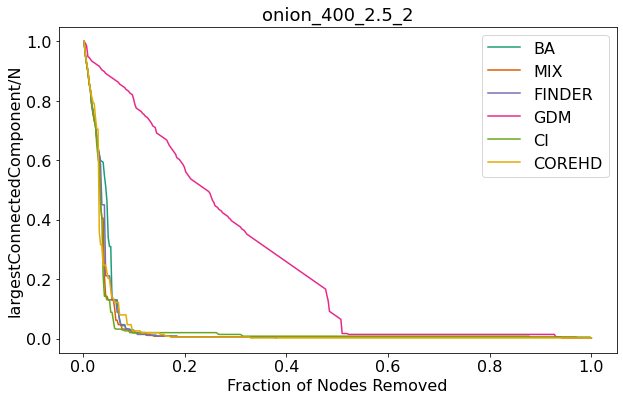

onion_300_2.5_4 ,

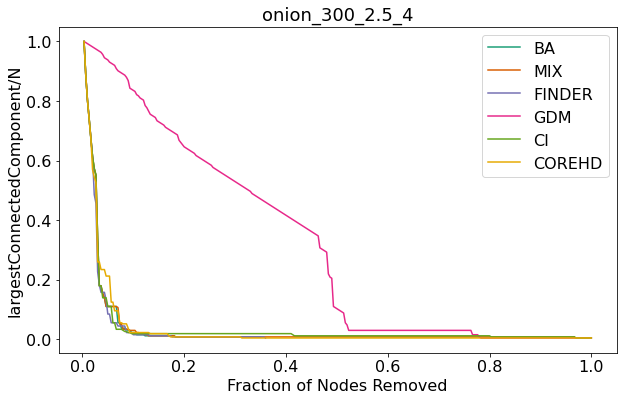

onion_400_2.5_4 ,

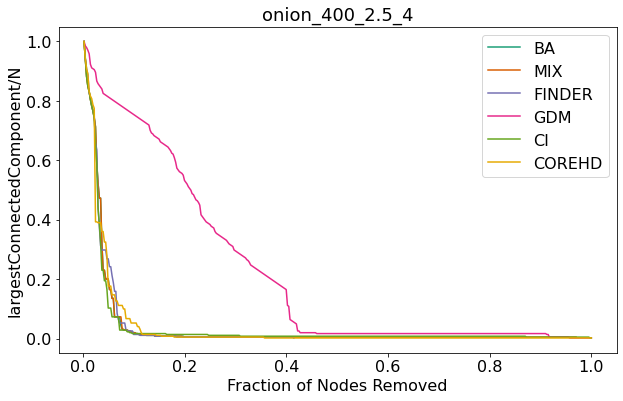

onion_300_2.5_3 ,

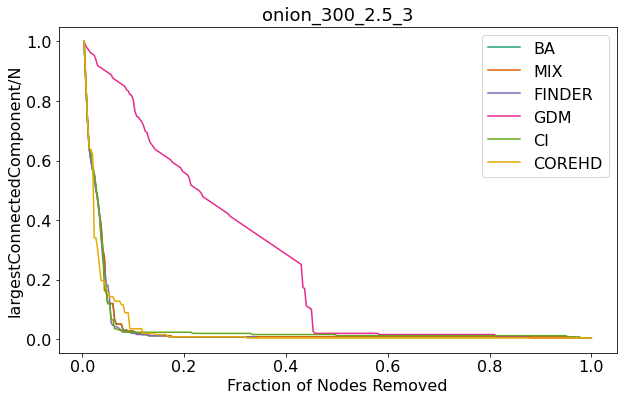

onion_300_2.5_2 ,

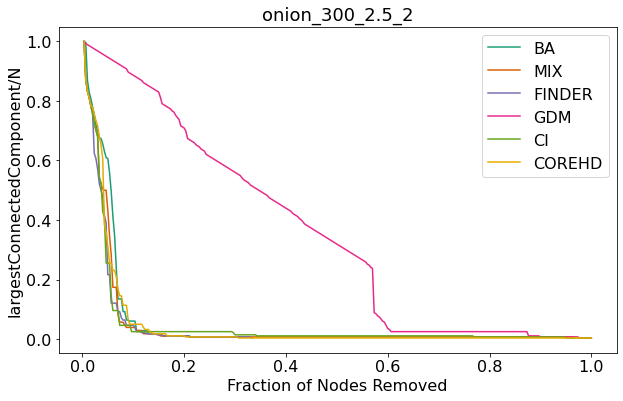

onion_500_2.5_5 ,

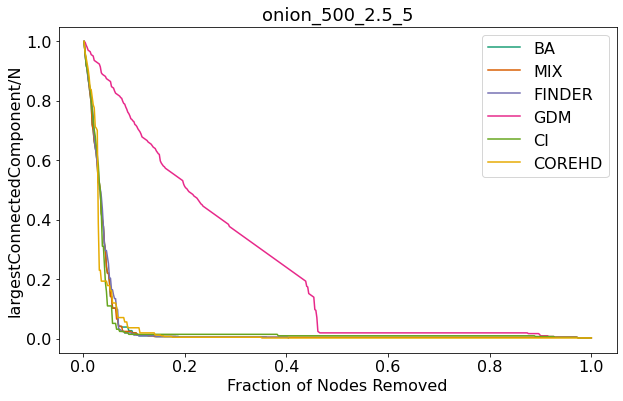

onion_400_2.5_1 ,

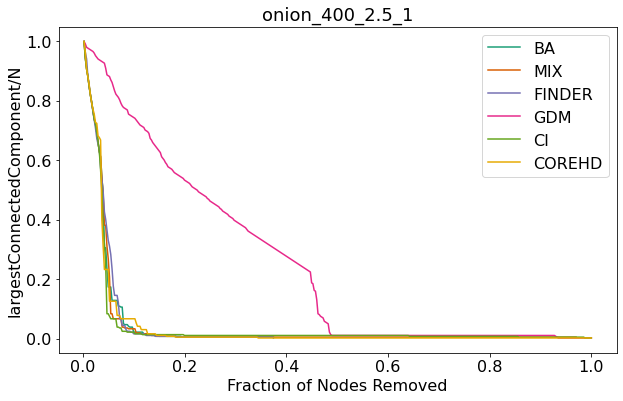

onion_100_2.5_2 ,

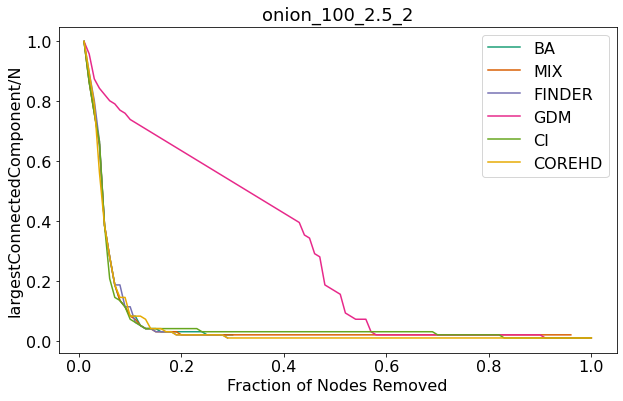

onion_100_2.5_1 ,

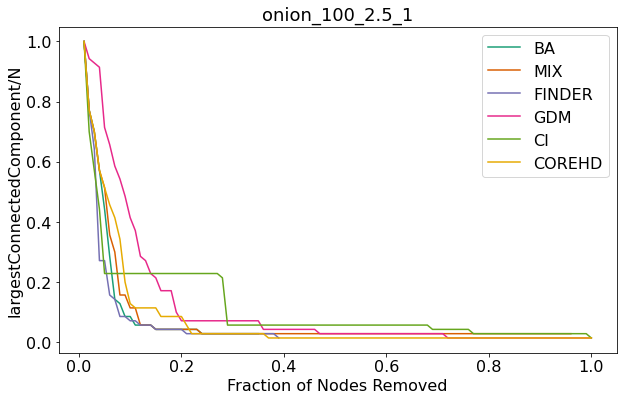

onion_500_2.5_1 ,

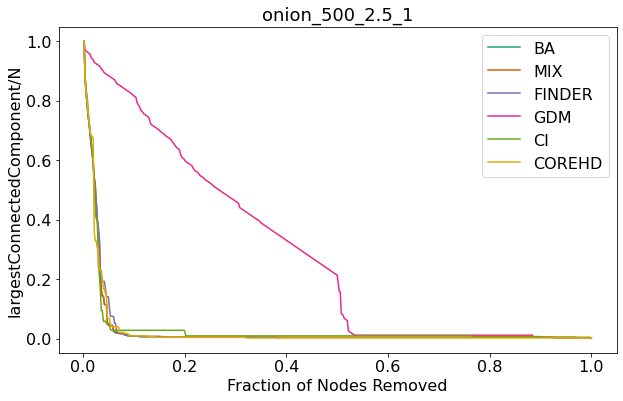

onion_300_2.5_5 ,

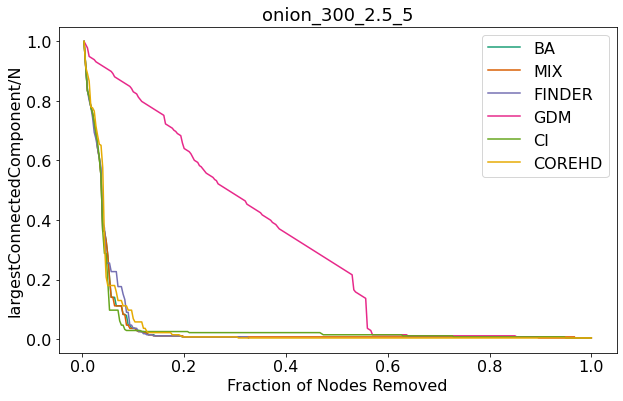

onion_200_2.5_4 ,

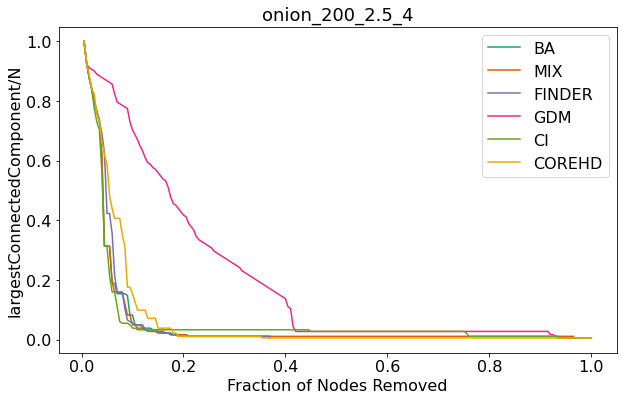

onion_200_2.5_1 ,

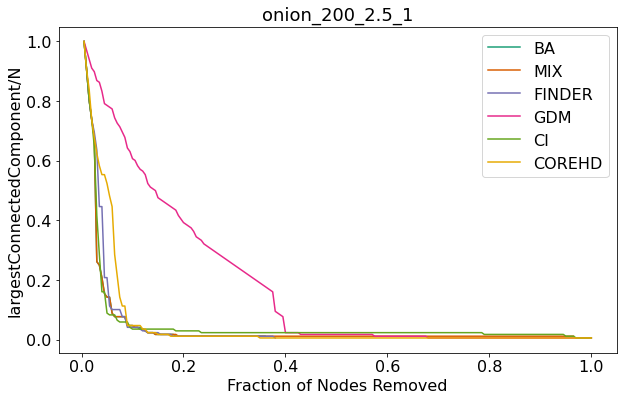

onion_100_2.5_3 ,

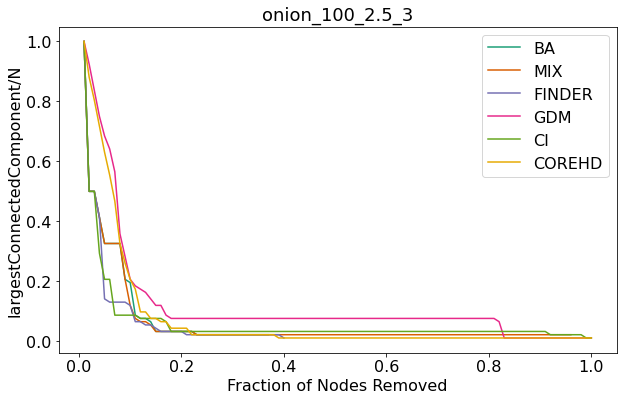

onion_100_2.5_4 ,

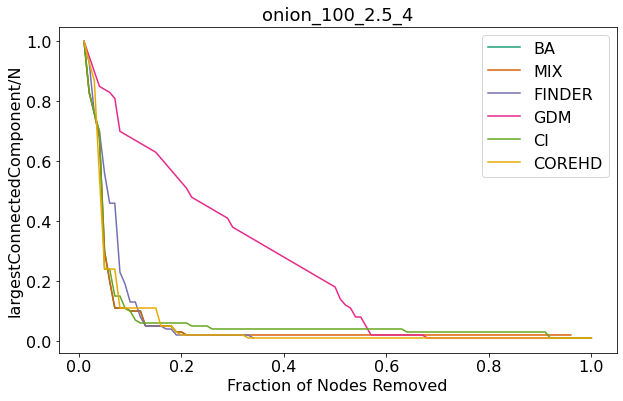

onion_200_2.5_3 ,

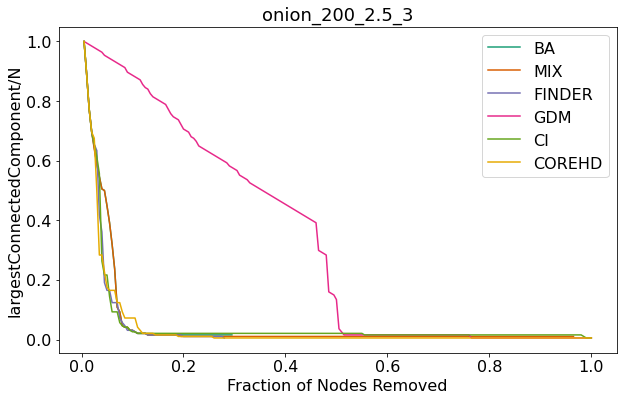

onion_500_2.5_3 ,

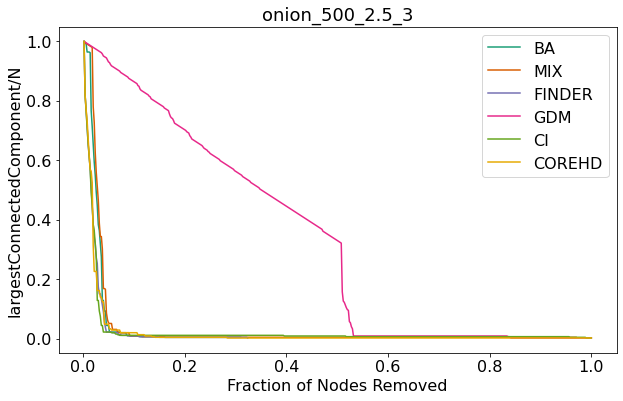

onion_500_2.5_4 ,

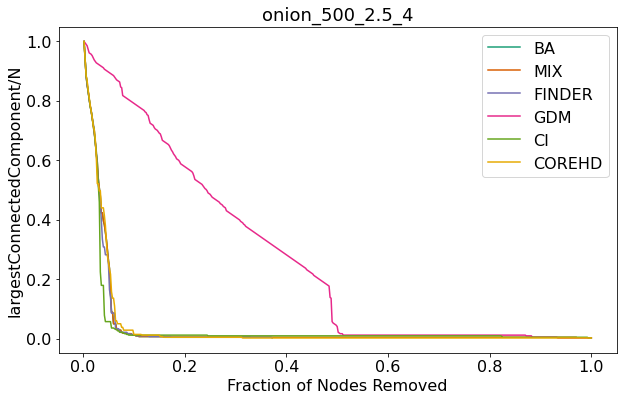

In [143]:
BA = 24000 #166000  # BEST ND 178000
MIX = 85000 #BEST ND 140500  
BA_New = 66500#225500 #166000  # BEST ND 178000
MIX_New =  85000 #87500#291000 #BEST ND 140500  
parameter = ["./utils/hyperparameters/BA/ba_params_Best.json","./utils/hyperparameters/Mix/mixed_params_All.json"]
parameter = ["./utils/hyperparameters/BA/ba_params_Best_New.json","./utils/hyperparameters/Mix/mixed_params_All.json"]
attacker= [BA,MIX]
attacker= [BA_New,MIX_New]
#file_list = ["foodweb-baywet","inf-USAir97","moreno_crime_projected",'opsahl-openflights','household','faa','facebook','powergrid','netscience']
file_list = ["corruption","inf-USAir97","moreno_crime_projected",'opsahl-openflights','household','netscience']
file_list = ["inf-USAir97","foodweb-baywet",'faa','facebook','household']
file_list = ["corruption","moreno_crime_projected",'household','netscience']
file_list = ["foodweb-baywet",'faa',"moreno_crime_projected"]
graph_path =  "./Dataset/Real/"
graph_path =  "./Dataset/SyntheticGraph/OnionModel/"
file_list = [f.split(".txt")[0] for f in listdir(graph_path) if isfile(join(graph_path, f))]
actions_list = get_from_json("./Figure/Compiled/HDA/SingleFigure/real_world.json")#{"largestConnectedComponent":{},"pairwiseConnectivity":{},"numberConnectedComponent":{}}
actions_list = visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],[attacker[1],parameter[1]],actions_list,save =True)
with open("./Figure/Compiled/HDA/SingleFigure/real_world.json", "w") as outfile:
    json.dump(actions_list, outfile, cls=NpEncoder)

# Real World Dataset: CNP Problem - Pairwise Connectivity Component

onion_200_2.5_2 ,

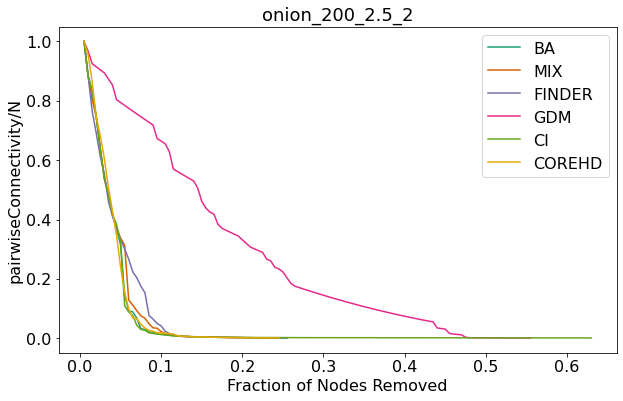

onion_200_2.5_5 ,

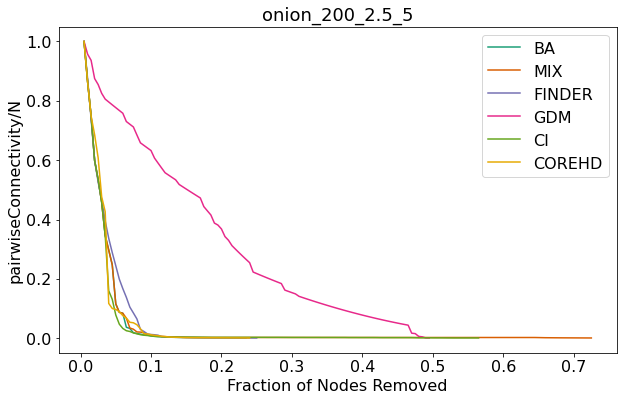

onion_400_2.5_3 ,

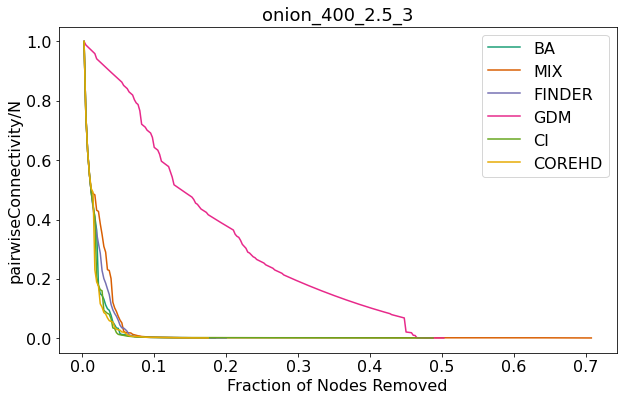

onion_500_2.5_2 ,

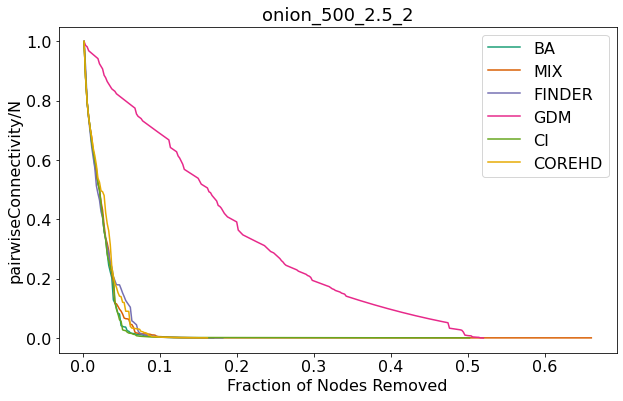

onion_100_2.5_5 ,

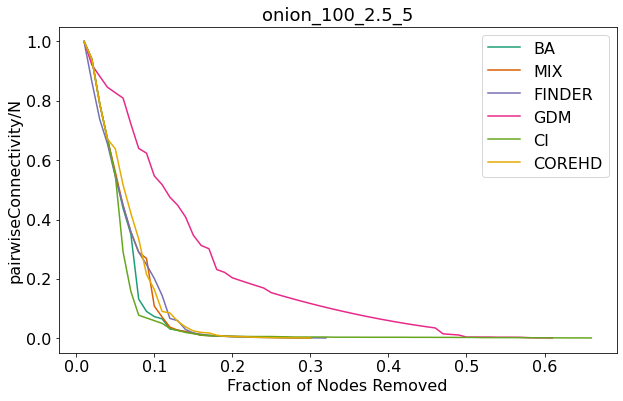

onion_400_2.5_5 ,

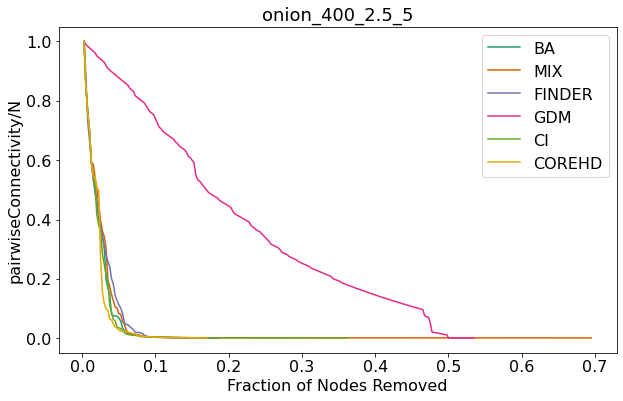

onion_300_2.5_1 ,

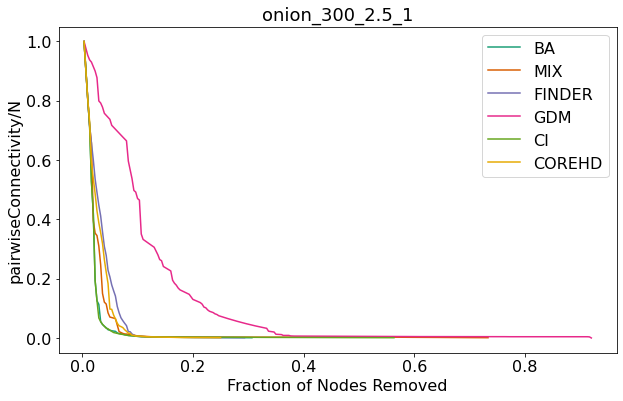

onion_400_2.5_2 ,

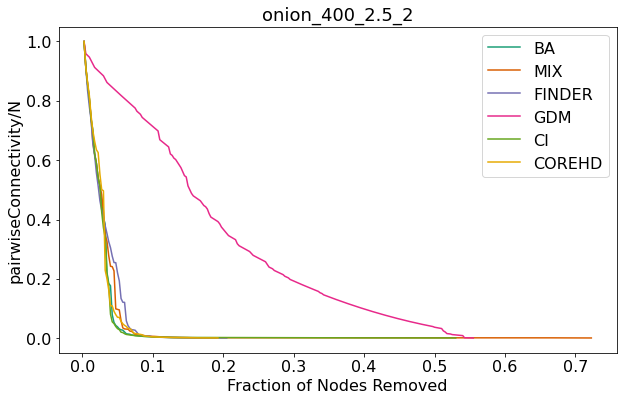

onion_300_2.5_4 ,

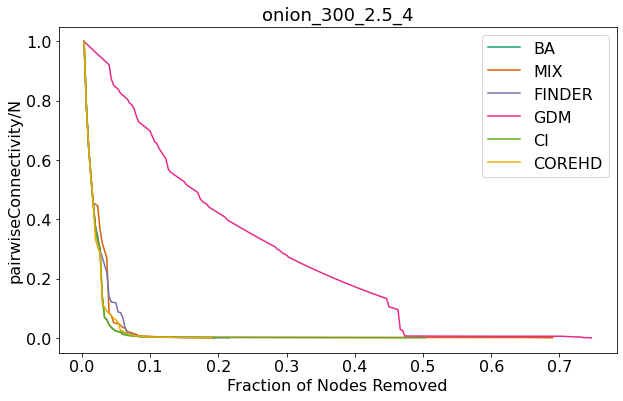

onion_400_2.5_4 ,

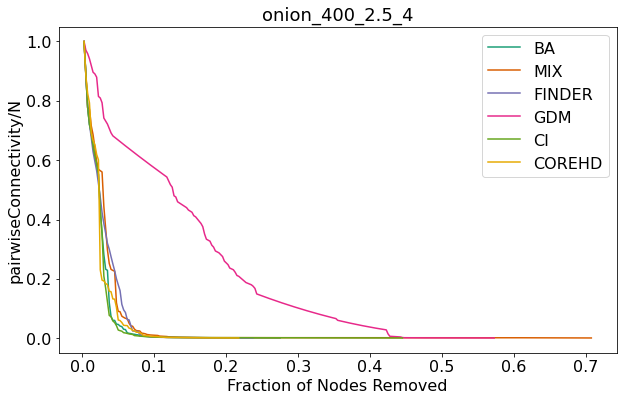

onion_300_2.5_3 ,

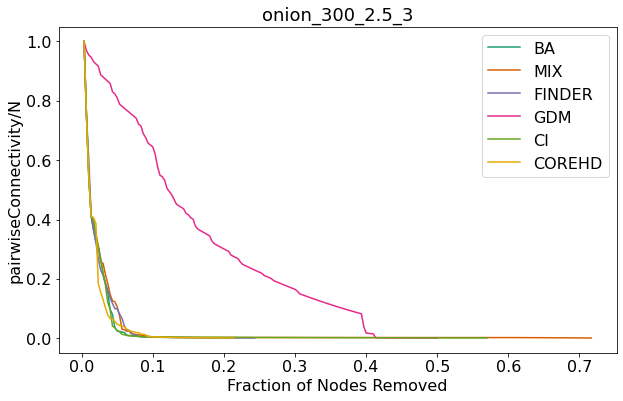

onion_300_2.5_2 ,

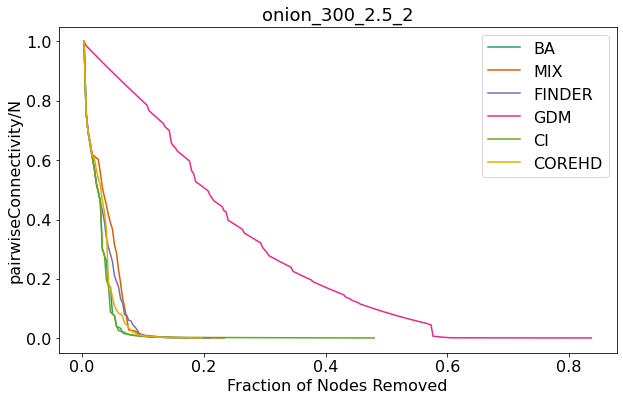

onion_500_2.5_5 ,

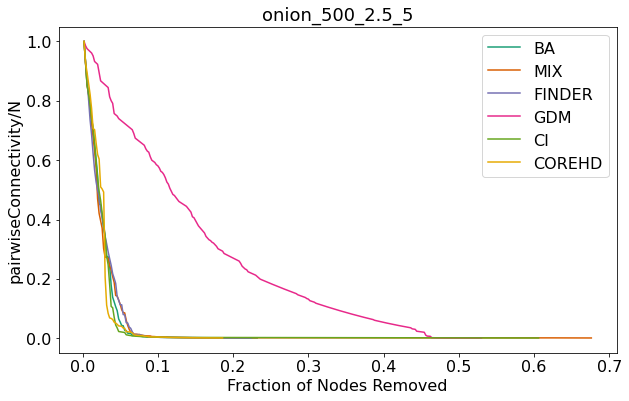

onion_400_2.5_1 ,

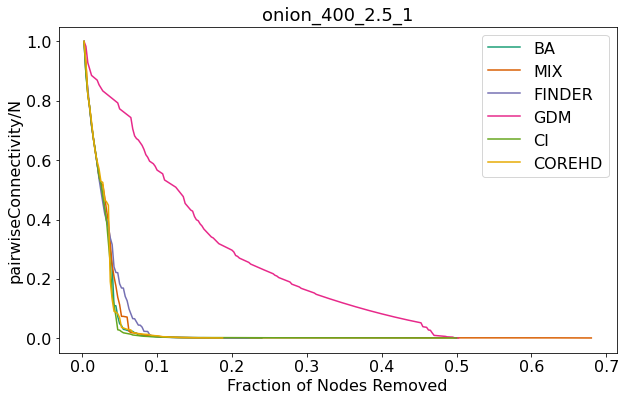

onion_100_2.5_2 ,

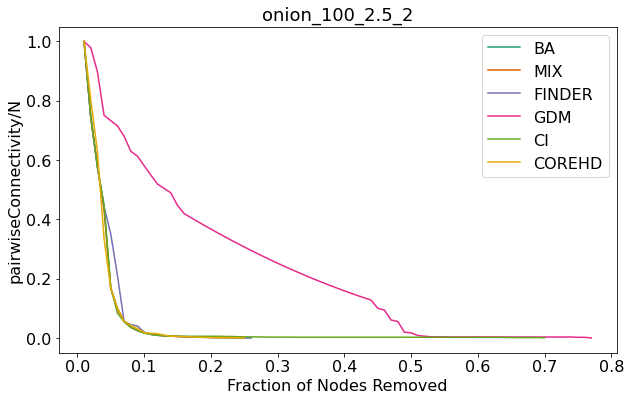

onion_100_2.5_1 ,

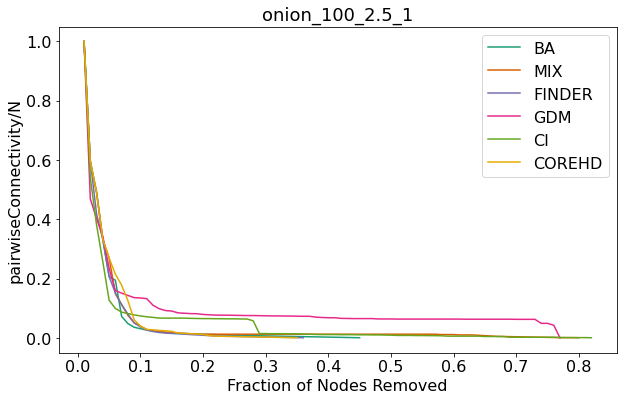

onion_500_2.5_1 ,

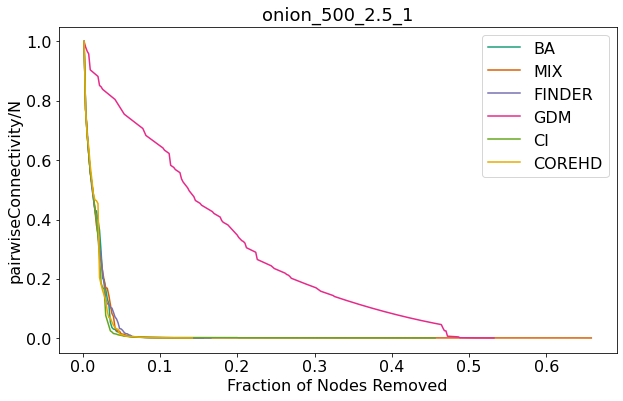

onion_300_2.5_5 ,

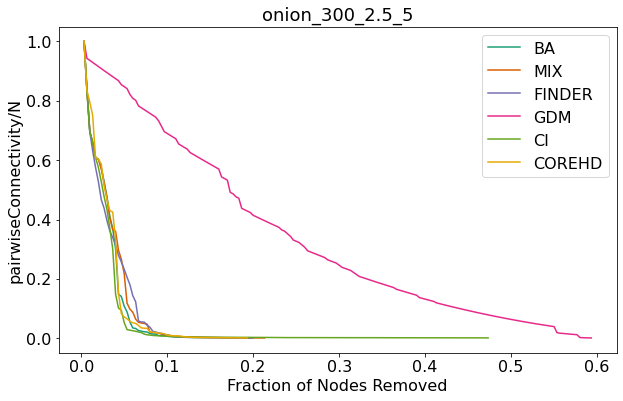

onion_200_2.5_4 ,

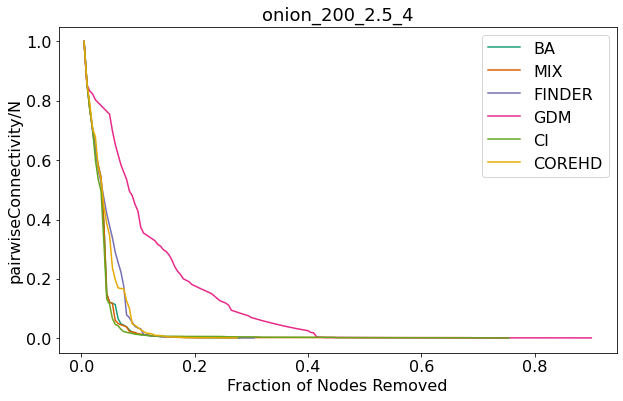

onion_200_2.5_1 ,

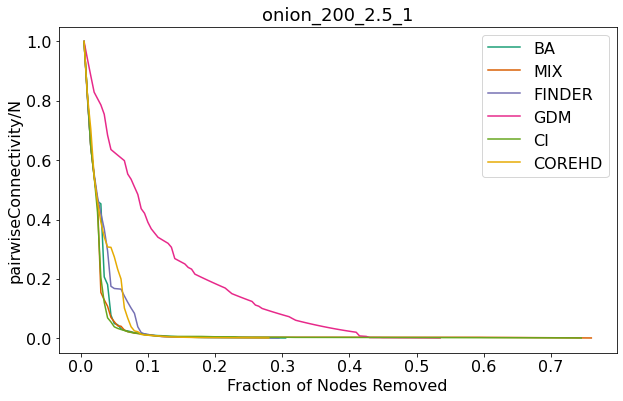

onion_100_2.5_3 ,

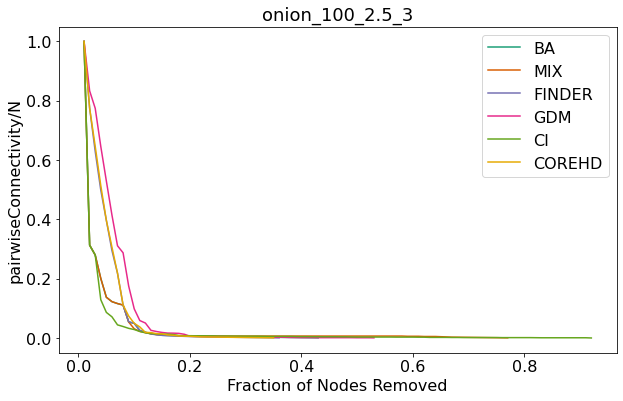

onion_100_2.5_4 ,

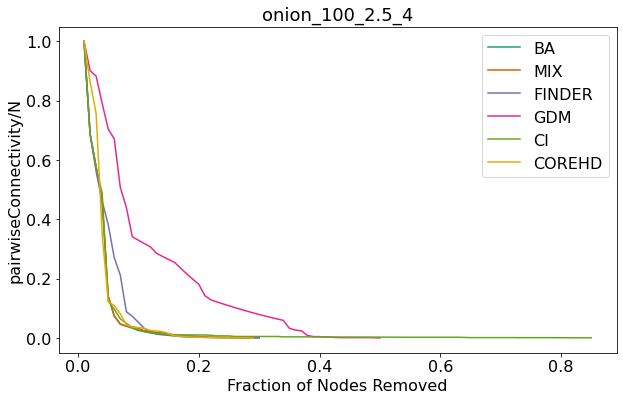

onion_200_2.5_3 ,

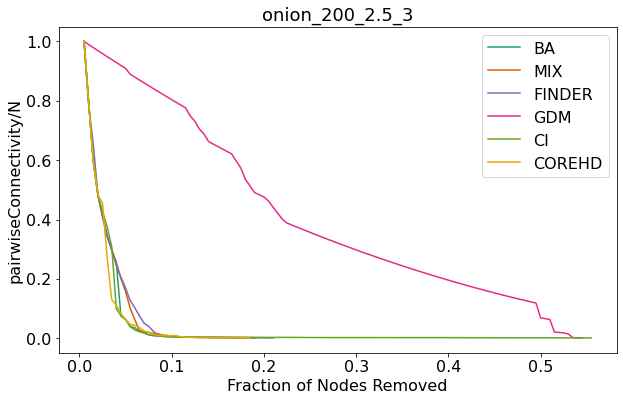

onion_500_2.5_3 ,

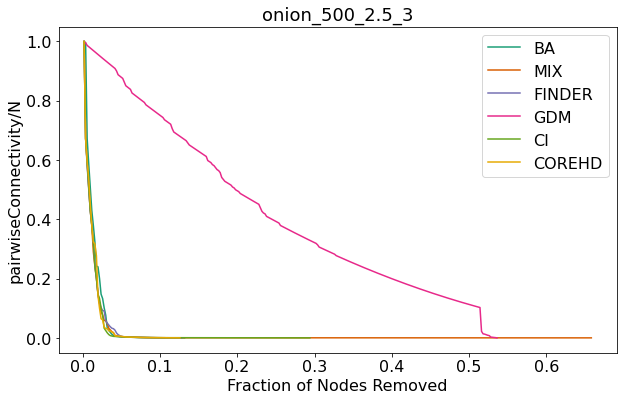

onion_500_2.5_4 ,

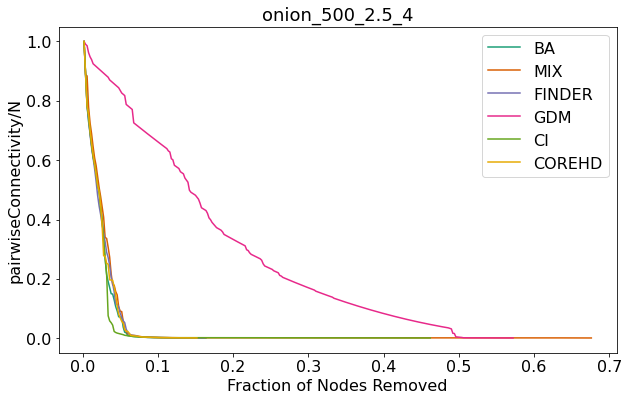

In [144]:
BA = 137000 # BEST ND 178000
MIX = 98500 #BEST ND140500  
BA_New = 52000
MIX_New =  56000
parameter = ["./utils/hyperparameters/BA/ba_params_CN.json","./utils/hyperparameters/Mix/mixed_params_CN.json"]
parameter = ["./utils/hyperparameters/BA/ba_params_CN_New.json","./utils/hyperparameters/Mix/mixed_params_CN_New.json"]
parameter = ["./utils/hyperparameters/BA/ba_params_CN_New.json","./utils/hyperparameters/Mix/mixed_params_CN.json"]
attacker= [BA_New,MIX_New]
attacker= [BA_New,MIX]
file_list = ["foodweb-baywet","inf-USAir97","moreno_crime_projected",'opsahl-openflights','household','faa','facebook','powergrid','netscience']
#file_list = ["test","corruption","foodweb-baywet","inf-USAir97","moreno_crime_projected"]
graph_path =  "./Dataset/Real/"
file_list = ["foodweb-baywet",'faa','facebook',]
file_list = ["inf-USAir97","foodweb-baywet",'faa','facebook','household']
file_list = ["inf-USAir97","foodweb-baywet",'faa']
file_list = ["corruption","moreno_crime_projected",'household','netscience']
#file_list = ["test","corruption","foodweb-baywet","inf-USAir97","moreno_crime_projected"]
file_list = ["foodweb-baywet",'faa',"moreno_crime_projected"]
graph_path =  "./Dataset/Real/"
graph_path =  "./Dataset/SyntheticGraph/OnionModel/"
file_list = [f.split(".txt")[0] for f in listdir(graph_path) if isfile(join(graph_path, f))]
actions_list = get_from_json("./Figure/Compiled/HDA/SingleFigure/real_world.json")#{"largestConnectedComponent":{},"pairwiseConnectivity":{},"numberConnectedComponent":{}}
actions_list = visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],[attacker[1],parameter[1]],actions_list,save =True)
with open("./Figure/Compiled/HDA/SingleFigure/real_world.json", "w") as outfile:
    json.dump(actions_list, outfile, cls=NpEncoder)

# Real World Dataset: MaxNum - Number of Connected Components

onion_200_2.5_2 ,

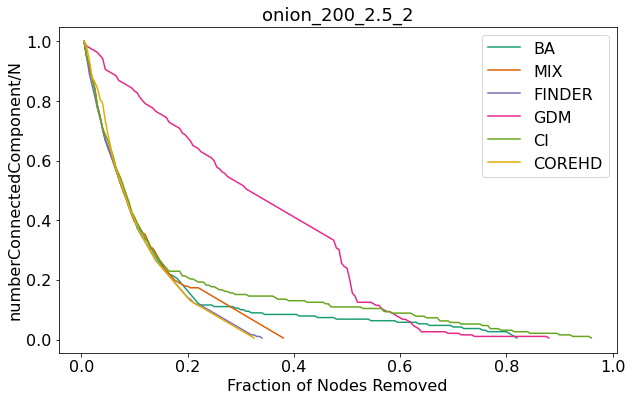

onion_200_2.5_5 ,

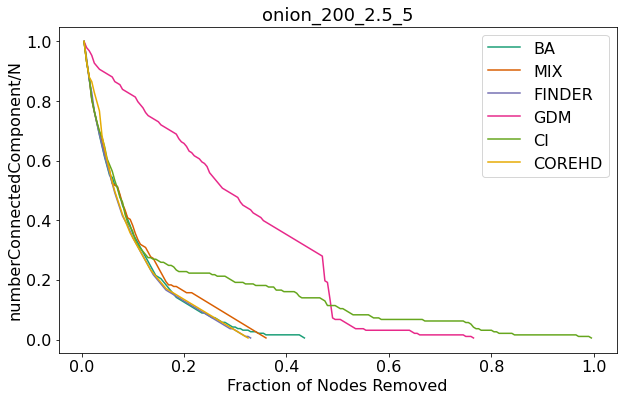

onion_400_2.5_3 ,

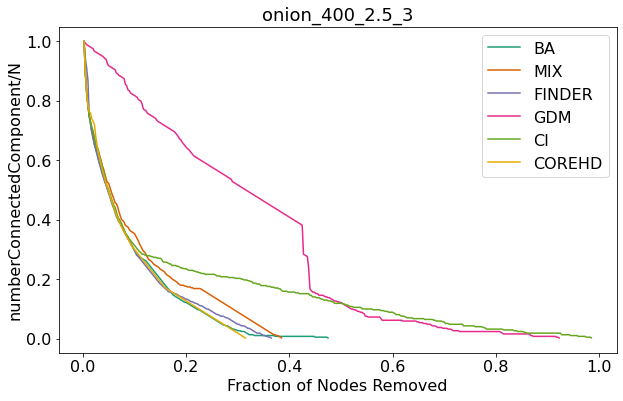

onion_500_2.5_2 ,

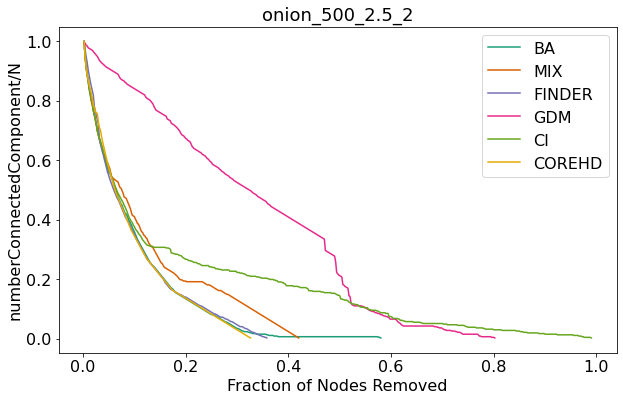

onion_100_2.5_5 ,

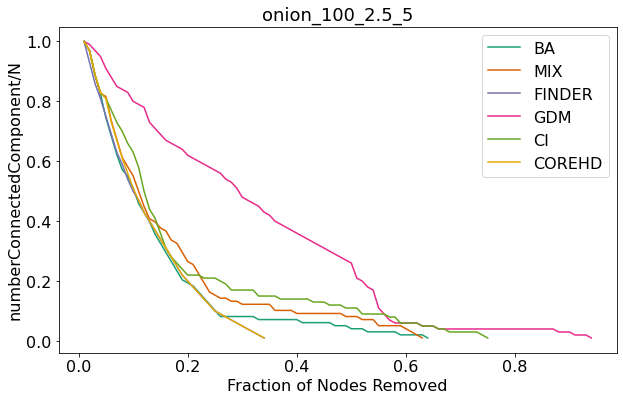

onion_400_2.5_5 ,

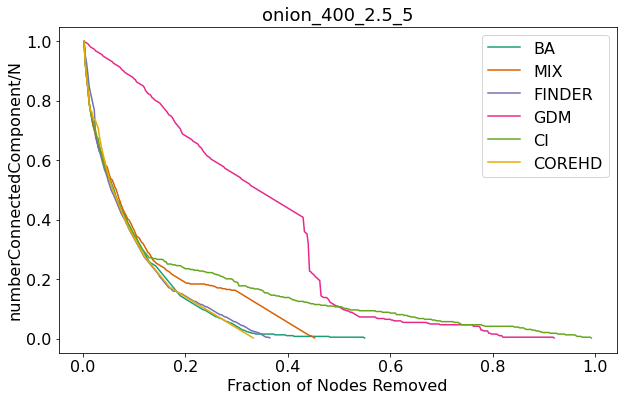

onion_300_2.5_1 ,

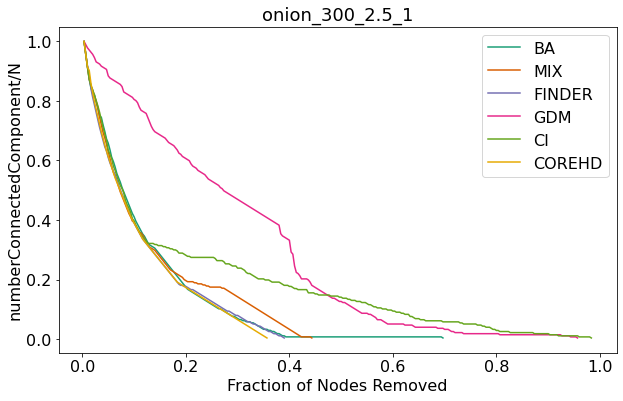

onion_400_2.5_2 ,

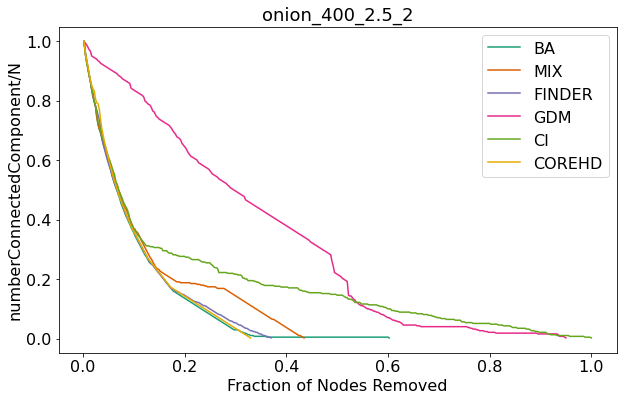

onion_300_2.5_4 ,

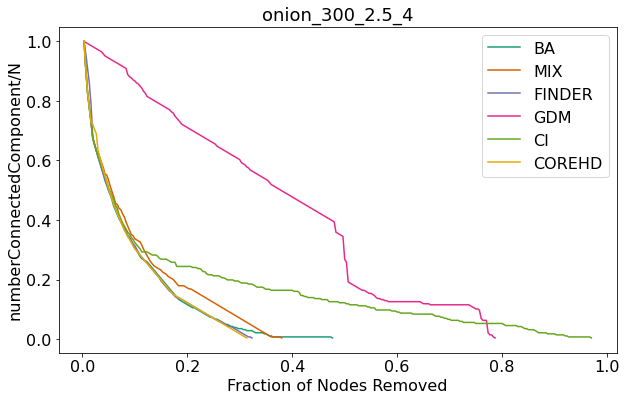

onion_400_2.5_4 ,

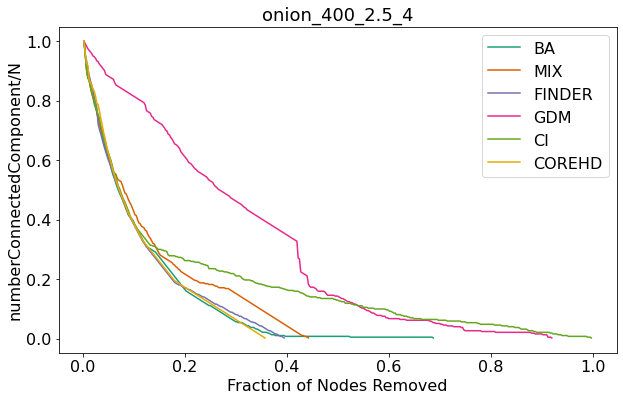

onion_300_2.5_3 ,

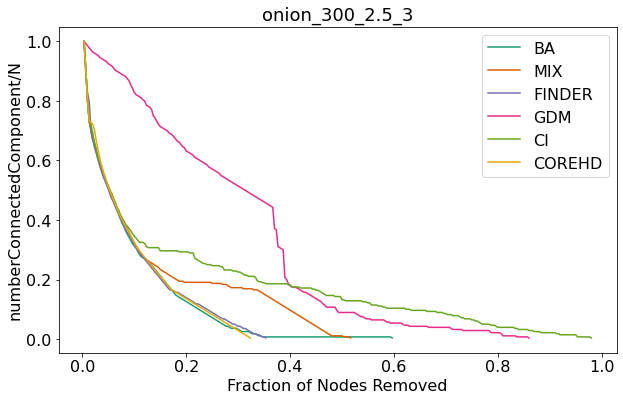

onion_300_2.5_2 ,

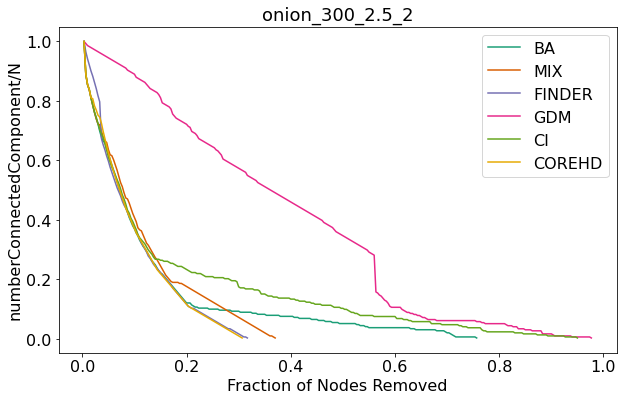

onion_500_2.5_5 ,

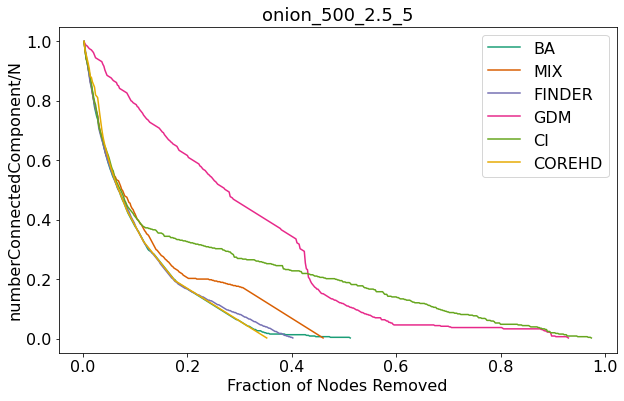

onion_400_2.5_1 ,

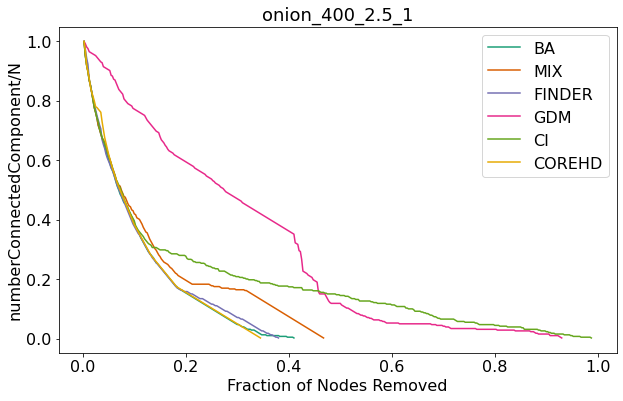

onion_100_2.5_2 ,

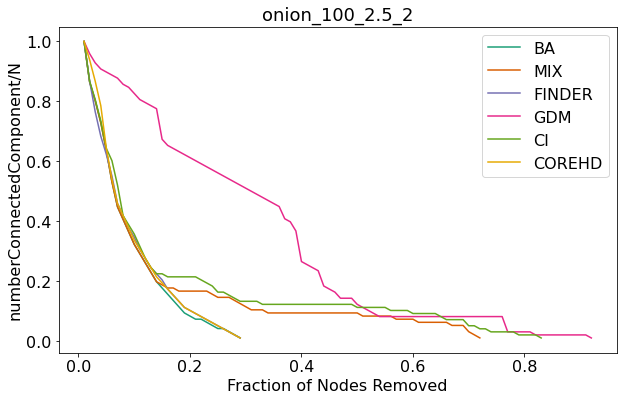

onion_100_2.5_1 ,

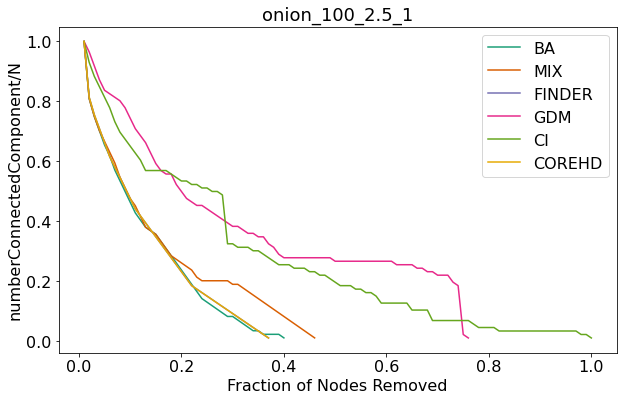

onion_500_2.5_1 ,

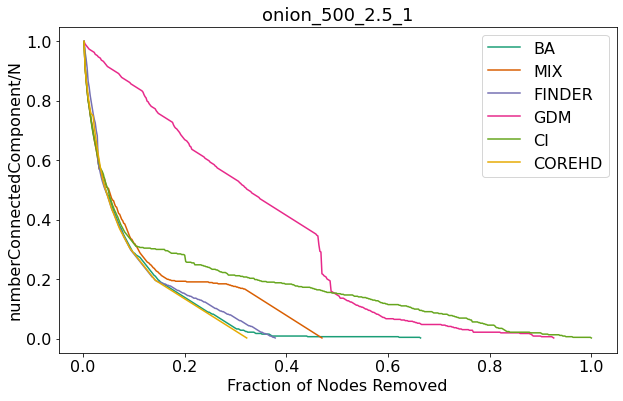

onion_300_2.5_5 ,

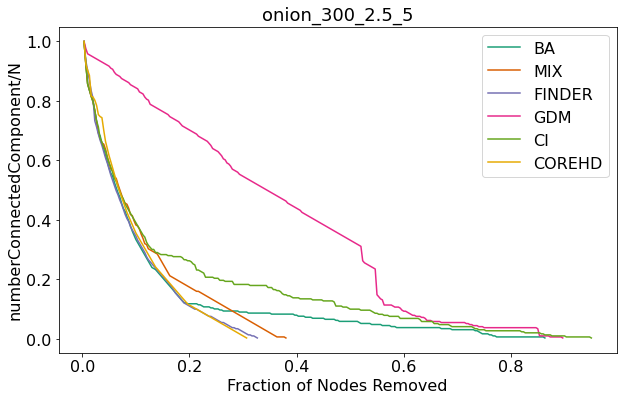

onion_200_2.5_4 ,

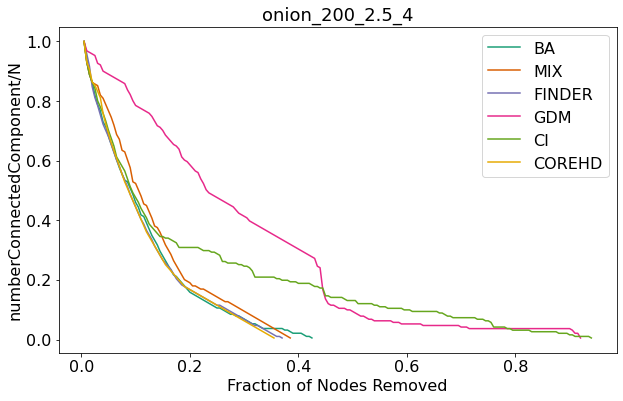

onion_200_2.5_1 ,

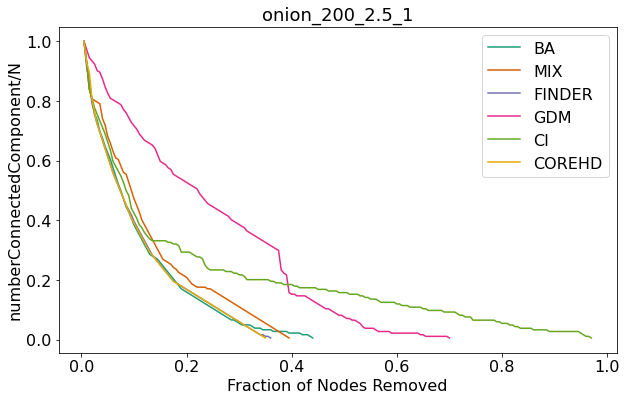

onion_100_2.5_3 ,

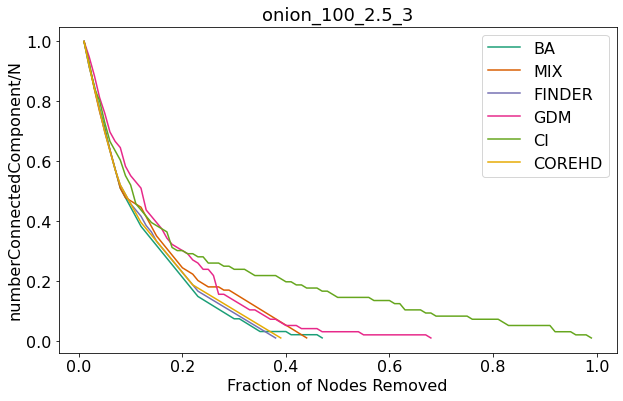

onion_100_2.5_4 ,

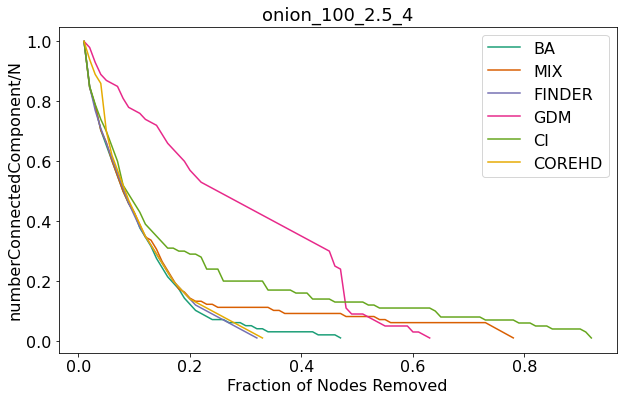

onion_200_2.5_3 ,

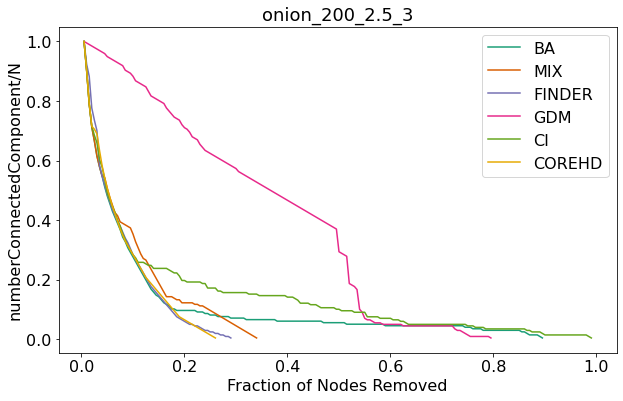

onion_500_2.5_3 ,

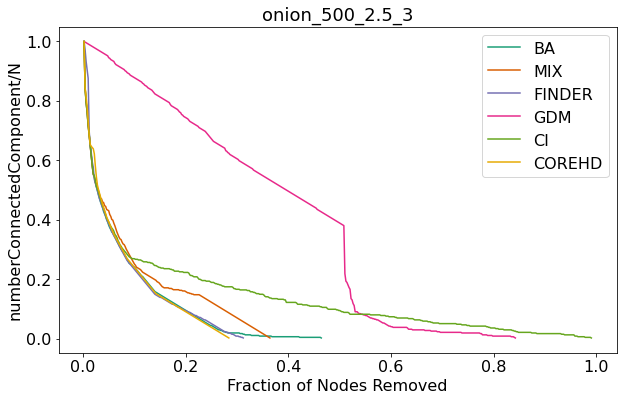

onion_500_2.5_4 ,

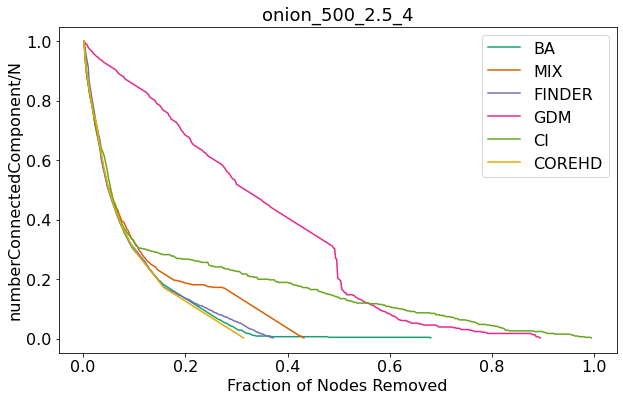

In [145]:
BA = 258500 # BEST ND 178000
MIX = 284000 #BEST ND140500  
parameter = ["./utils/hyperparameters/BA/ba_params_MaxNum.json","./utils/hyperparameters/Mix/mixed_params_MaxNum.json"]
attacker= [BA,MIX]
file_list = ["foodweb-baywet","inf-USAir97","moreno_crime_projected",'opsahl-openflights','household','faa','facebook','powergrid','netscience']
file_list = ["corruption","inf-USAir97","moreno_crime_projected",'opsahl-openflights','household','netscience']
#file_list = ["foodweb-baywet",'faa','facebook','powergrid']
#file_list = ["test","corruption","foodweb-baywet","inf-USAir97","moreno_crime_projected"]
file_list = ["inf-USAir97","foodweb-baywet",'faa','facebook','household']
file_list = ["inf-USAir97","foodweb-baywet",'faa']
file_list = ["corruption","moreno_crime_projected",'household','netscience']
file_list = ["foodweb-baywet",'faa',"moreno_crime_projected"]
graph_path =  "./Dataset/Real/"
graph_path =  "./Dataset/SyntheticGraph/OnionModel/"
file_list = [f.split(".txt")[0] for f in listdir(graph_path) if isfile(join(graph_path, f))]
actions_list = get_from_json("./Figure/Compiled/HDA/SingleFigure/real_world.json")#{"largestConnectedComponent":{},"pairwiseConnectivity":{},"numberConnectedComponent":{}}
actions_list =visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],[attacker[1],parameter[1]],actions_list,save =True)
with open("./Figure/Compiled/HDA/SingleFigure/real_world.json", "w") as outfile:
    json.dump(actions_list, outfile, cls=NpEncoder)

onion_200_2.5_2 2
onion_200_2.5_5 5
onion_400_2.5_3 3
onion_500_2.5_2 2
onion_100_2.5_5 5
onion_400_2.5_5 5
onion_300_2.5_1 1


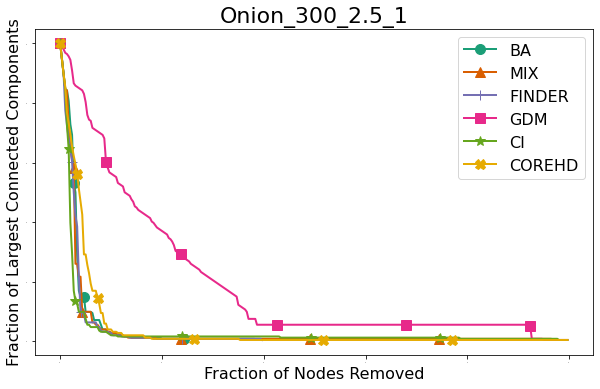

onion_400_2.5_2 2
onion_300_2.5_4 4
onion_400_2.5_4 4
onion_300_2.5_3 3
onion_300_2.5_2 2
onion_500_2.5_5 5
onion_400_2.5_1 1


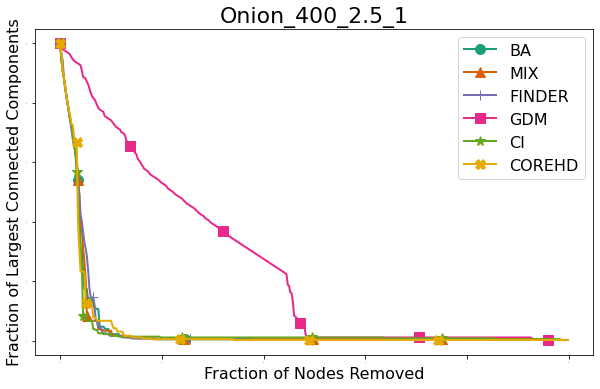

onion_100_2.5_2 2
onion_100_2.5_1 1


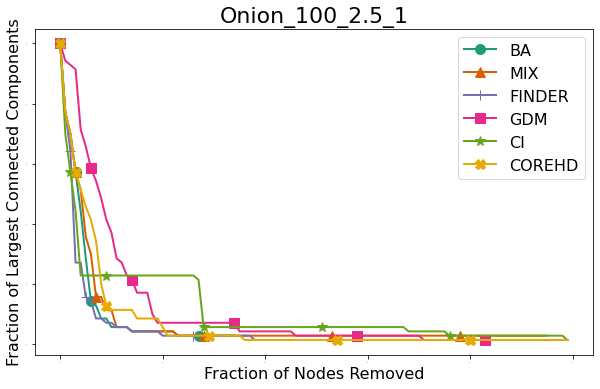

onion_500_2.5_1 1


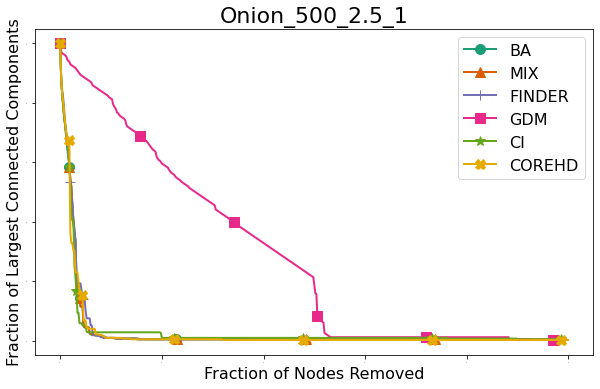

onion_300_2.5_5 5
onion_200_2.5_4 4
onion_200_2.5_1 1


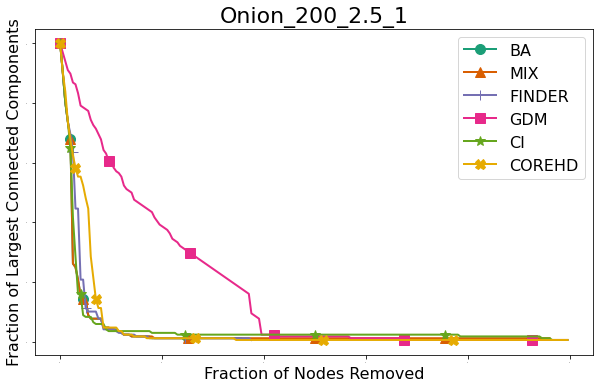

onion_100_2.5_3 3
onion_100_2.5_4 4
onion_200_2.5_3 3
onion_500_2.5_3 3
onion_500_2.5_4 4
onion_200_2.5_2 2
onion_200_2.5_5 5
onion_400_2.5_3 3
onion_500_2.5_2 2
onion_100_2.5_5 5
onion_400_2.5_5 5
onion_300_2.5_1 1


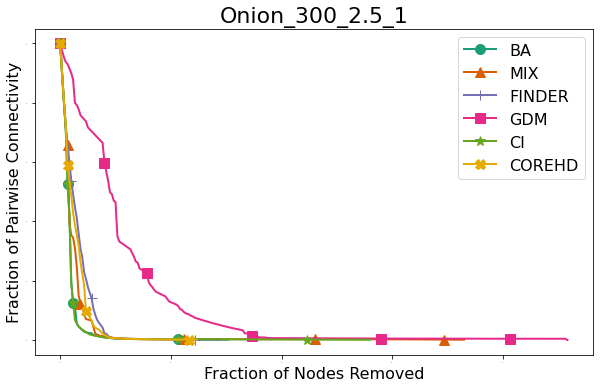

onion_400_2.5_2 2
onion_300_2.5_4 4
onion_400_2.5_4 4
onion_300_2.5_3 3
onion_300_2.5_2 2
onion_500_2.5_5 5
onion_400_2.5_1 1


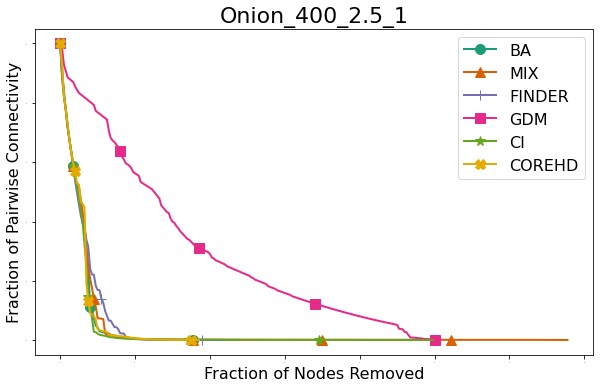

onion_100_2.5_2 2
onion_100_2.5_1 1


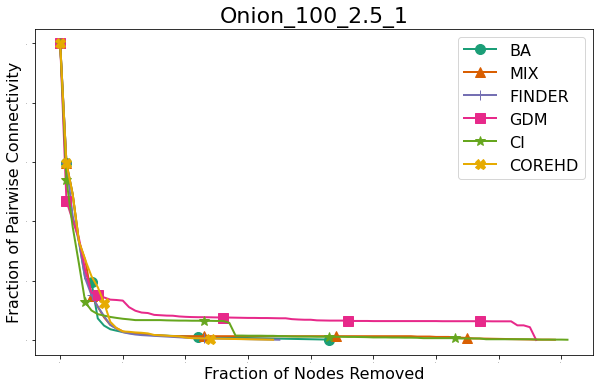

onion_500_2.5_1 1


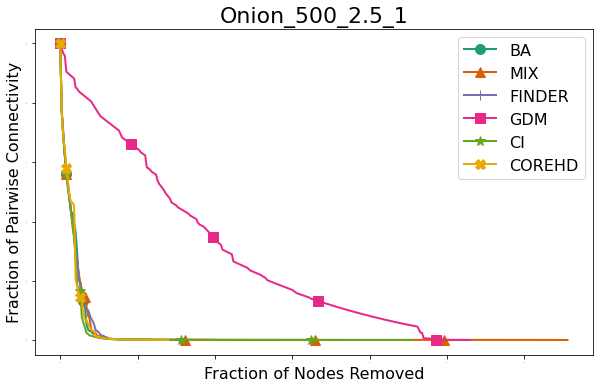

onion_300_2.5_5 5
onion_200_2.5_4 4
onion_200_2.5_1 1


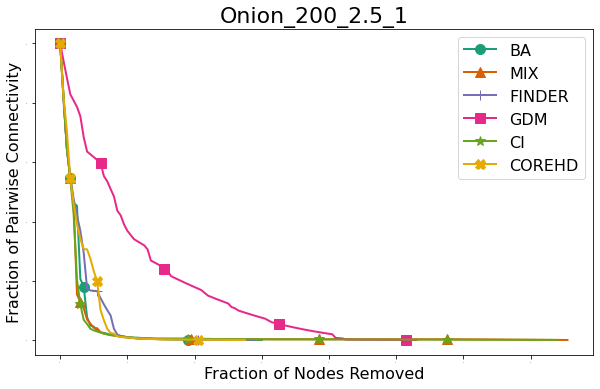

onion_100_2.5_3 3
onion_100_2.5_4 4
onion_200_2.5_3 3
onion_500_2.5_3 3
onion_500_2.5_4 4
onion_200_2.5_2 2
onion_200_2.5_5 5
onion_400_2.5_3 3
onion_500_2.5_2 2
onion_100_2.5_5 5
onion_400_2.5_5 5
onion_300_2.5_1 1


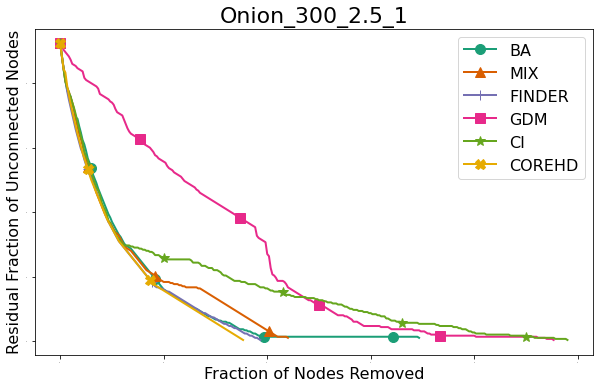

onion_400_2.5_2 2
onion_300_2.5_4 4
onion_400_2.5_4 4
onion_300_2.5_3 3
onion_300_2.5_2 2
onion_500_2.5_5 5
onion_400_2.5_1 1


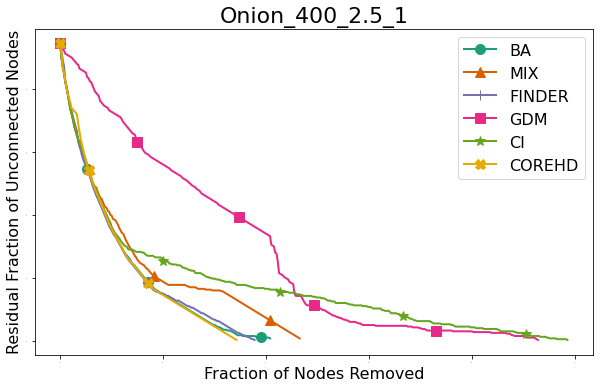

onion_100_2.5_2 2
onion_100_2.5_1 1


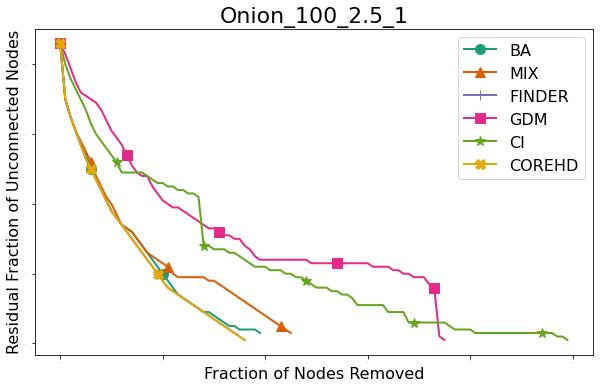

onion_500_2.5_1 1


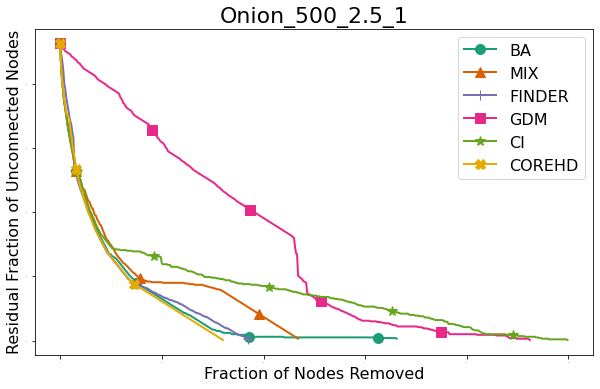

onion_300_2.5_5 5
onion_200_2.5_4 4
onion_200_2.5_1 1


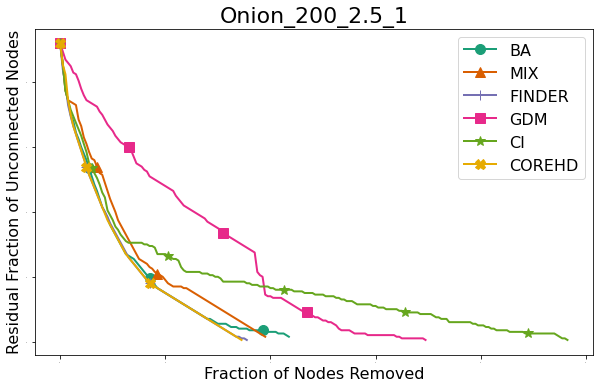

onion_100_2.5_3 3
onion_100_2.5_4 4
onion_200_2.5_3 3
onion_500_2.5_3 3
onion_500_2.5_4 4


In [148]:
import matplotlib
def plot_figure(result,graph_name_list):
    font = {'weight' : 'normal',
        'size'   : 16}
    matplotlib.rc('font', **font)
    for fname in result:
        if fname== "MinMax": 
            color_model = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02']
            labeling = ['ba', 'mix', 'finder', 'gdm','ci','corehd']
            marker = ['o', '^', "+", "s", "*","X"]
            condMaxNum = False
            ylabel = "Fraction of Largest Connected Components"
        elif fname== "CNP":
            color_model = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02']
            labeling = ['ba', 'mix', 'finder', 'gdm','ci','corehd']
            marker = ['o', '^', "+", "s", "*","X"]
            ylabel = "Fraction of Pairwise Connectivity"
            condMaxNum = False
        else:
            color_model = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02']
            model_name = ['ba_MaxNum', 'mix_MaxNum_inf','finder_MaxNum','gdm_MaxNum', 'ci_MaxNum','corehd_new_MaxNum']
            labeling = ['ba', 'mix', 'finder', 'gdm','ci','corehd']
            marker = ['o', '^', "+", "s", "*","X"]
            ylabel = "Residual Fraction of Unconnected Nodes"
            condMaxNum = True

        for graph_name in graph_name_list:
            print(graph_name,int(graph_name.split("_")[-1]))
            if int(graph_name.split("_")[-1]) >= 2:
                continue
            GRAPH, map = input_graph( "./Dataset/SyntheticGraph/OnionModel/",graph_name)
            #GRAPH, map = input_graph( "./Dataset/Real/",graph_name)
            N = GRAPH.vcount()
            x =  np.flip(np.arange(N+1)[N:0:-1]/N)
            x = np.arange(0,N+1)/N
            plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
            plt.figure(figsize=(10,6))        
            #for model_code, model in enumerate(result[fname][graph_name]):
            for model_code, model in enumerate(labeling):
                if condMaxNum:
                    l = np.array(result[fname][graph_name][model])
                    lcc = (l[-1] - l + 1)/l[-1]   
                    lcc = (N - l + 1)/N  
                else:
                    lcc = np.array(result[fname][graph_name][model])
                    lcc = lcc /lcc[0]
                
                plt.plot(x[:len(lcc)],np.array(lcc), marker=marker[model_code],markevery=0.2, markerfacecolor=color_model[model_code], markersize=10, color=color_model[model_code], linewidth=2,label= labeling[model_code].upper())
                #plt.plot( color = color_model[color_code],label= labeling[color_code].upper())
            plt.title(graph_name.capitalize(), fontdict={'fontsize': 22})
            plt.legend(loc="upper right")
            plt.xlabel("Fraction of Nodes Removed")
            plt.ylabel(ylabel)
            plt.xticks(fontsize=0)
            plt.yticks(fontsize=0)
            #if save:
            plt.savefig("./Figure/Compiled/HDA/SingleFigure/"+fname+"_"+graph_name+".png",bbox_inches='tight', pad_inches=0.1)
            plt.show()
graph_name = ["corruption","moreno_crime_projected",'household','netscience',"inf-USAir97","foodweb-baywet",'faa','facebook','household']
graph_name = ["moreno_crime_projected","foodweb-baywet",'faa']
graph_path =  "./Dataset/SyntheticGraph/OnionModel/"
graph_name = [f.split(".txt")[0] for f in listdir(graph_path) if isfile(join(graph_path, f))]
plot_figure(actions_list,graph_name)

In [104]:
import itertools
from collections.abc import Iterable
import csv
def transpose(data):
    data = list(map(list, itertools.zip_longest(*data, fillvalue=None)))
    return data
def convert_csv(data):
    for obj in data:
        csv_data = []
        for network in data[obj]:
            GRAPH, map = input_graph( "./Dataset/Real/",network)
            N = GRAPH.vcount()
            x = np.arange(0,N+1)/N
            buffer = [network+"_x"]
            buffer+= x.tolist()
            csv_data.append(buffer)
            if obj== "MinMax": 
                condMaxNum = False
            elif obj== "CNP":
                condMaxNum = False
            else:
                condMaxNum = True
            for model in data[obj][network]:
                if condMaxNum:
                    l = np.array(data[obj][network][model],dtype ='>i4')
                    lcc = (N - l + 1)/N   
                else:
                    lcc = np.array(data[obj][network][model],dtype ='>i4')
                    lcc = lcc /lcc[0]
                buffer = [network+"_"+model]
                buffer+= lcc.tolist()
                csv_data.append(buffer)
        csv_data = transpose(csv_data)
        with open("./Figure/Compiled/HDA/SingleFigure/single_feature_"+obj+".csv", 'w') as csvfile:
            csvwriter = csv.writer(csvfile, delimiter=',')
            csvwriter.writerows(csv_data)
convert_csv(actions_list)   

In [133]:
i = 0
for f in actions_list["MinMax"]:
    if f.split("_")[0]=="Onion":
        print(f,i)
        i+=1

Onion_200_2.5_5 0
Onion_200_2.5_3 1
Onion_300_2.5_2 2
Onion_200_2.5_2 3
Onion_100_2.5_4 4
Onion_500_2.5_1 5
Onion_200_2.5_4 6
Onion_500_2.5_4 7
Onion_300_2.5_3 8
Onion_500_2.5_5 9
Onion_500_2.5_3 10
Onion_100_2.5_2 11
Onion_100_2.5_5 12
Onion_500_2.5_2 13
Onion_300_2.5_5 14
Onion_300_2.5_1 15
Onion_100_2.5_1 16
Onion_100_2.5_3 17
Onion_200_2.5_1 18
Onion_300_2.5_4 19
